In [1]:
# Importando as dependências
from quantumnet.components import Controller, Network
from quantumnet.utils import generate_random_request, clear_file, register_time_slot_and_rules
from quantumnet.objects import time

In [2]:
# Caminho do arquivo de saída
path = "resultados/hibrido/n_regras.csv"
# Limpa o arquivo de saída
clear_file(path)
# Sobre a rede
rede = Network()
rede.n_initial_eprs = 10
rede.n_initial_qubits = 10
row, col = 3, 4
rede.set_ready_topology("Grade", (row, col))
# Sobre o controlador
controlador = Controller(rede)
controlador.default_ttl = 50
# Sobre as requisições
fmin_range = (0.5, 1)
neprs_range = (2, 4)
num_requests = 100
requests = list(generate_random_request(len(rede.hosts)-1, fmin_range, neprs_range) for i in range(num_requests))

In [3]:
hosts = rede.hosts
for alice in hosts:
    for bob in hosts:
        controlador.add_match_route_rule_in_host_proactive(alice, bob, (0.5, 0.6), 5)
        controlador.add_match_route_rule_in_host_proactive(alice, bob, (0.8, 0.9), 5)

In [4]:
def update_time(time_for_update):
    """
    Atualiza o tempo e as regras

    Args:
        time_for_update (int): Tempo para incrementar o time-slot.
    """
    # Atualiza o tempo
    for t in range(time_for_update):
        time.increment()
        
        # Registra o número de regras e o tempo
        register_time_slot_and_rules(time.get_current_time(), controlador.get_number_of_rules(), path)
        
        # Atualiza os recursos de 10 em 10
        if time.get_current_time() % 10 == 0:
            rede.refresh_resources(num_qubits=10, num_eprs=10)
            print(f"[Time {time.get_current_time()}] Recursos atualizados")

In [5]:
for request in requests:
        print(f"[Time {time.get_current_time()}] Processando requisição {request}...")
        alice = rede.get_host(request.alice)
        rule = alice.find_rule_by_request(request)

        if rule == False:  # Caso não exista um match na tabela
            request.starttime = time.get_current_time()
            update_time(3)
            controlador.add_match_route_rule_in_host_reactive(request)
            rule = alice.find_rule_by_request(request)
            controlador.run_rule(rule[1])
            request.endtime = time.get_current_time() 
            
        else:  # Caso já exista a regra
            request.starttime = time.get_current_time()
            update_time(1)
            controlador.run_rule(rule[1])
            request.endtime = time.get_current_time()
            
        # Exibir informações da requisição
        print(f"Request {request}: Start Time = {request.starttime}, End Time = {request.endtime}")

[Time 0] Processando requisição R-E14C20...
Time-slot 1 registrado com 288 regras.
[BasicRuleProactive] Passo: 1
[BasicRuleProactive] Ação: CreateEPR(6-2)
Request R-E14C20: Start Time = 0, End Time = 1
[Time 1] Processando requisição R-D62330...
Time-slot 2 registrado com 288 regras.
[BasicRuleProactive] Passo: 1
[BasicRuleProactive] Ação: CreateEPR(1-0)
[BasicRuleProactive] Ação: CreateEPR(0-4)
[BasicRuleProactive] Passo: 2
[BasicRuleProactive] Ação: Swap(1-0-4)
Running Swap(1-0-4)
Request R-D62330: Start Time = 1, End Time = 2
[Time 2] Processando requisição R-D0BCE0...
Time-slot 3 registrado com 288 regras.
Time-slot 4 registrado com 288 regras.
Time-slot 5 registrado com 288 regras.
Decisão aplicada: (Normal E2E,)
[BasicRule] Passo: 1
[BasicRule] Passo: 2
[BasicRule] Ação: Swap(7-6-10)
Running Swap(7-6-10)
Request R-D0BCE0: Start Time = 2, End Time = 5
[Time 5] Processando requisição R-195100...
Time-slot 6 registrado com 289 regras.
Time-slot 7 registrado com 289 regras.
Time-slot

Colunas encontradas: Index(['Time_Slot', 'Numero_de_Regras'], dtype='object')


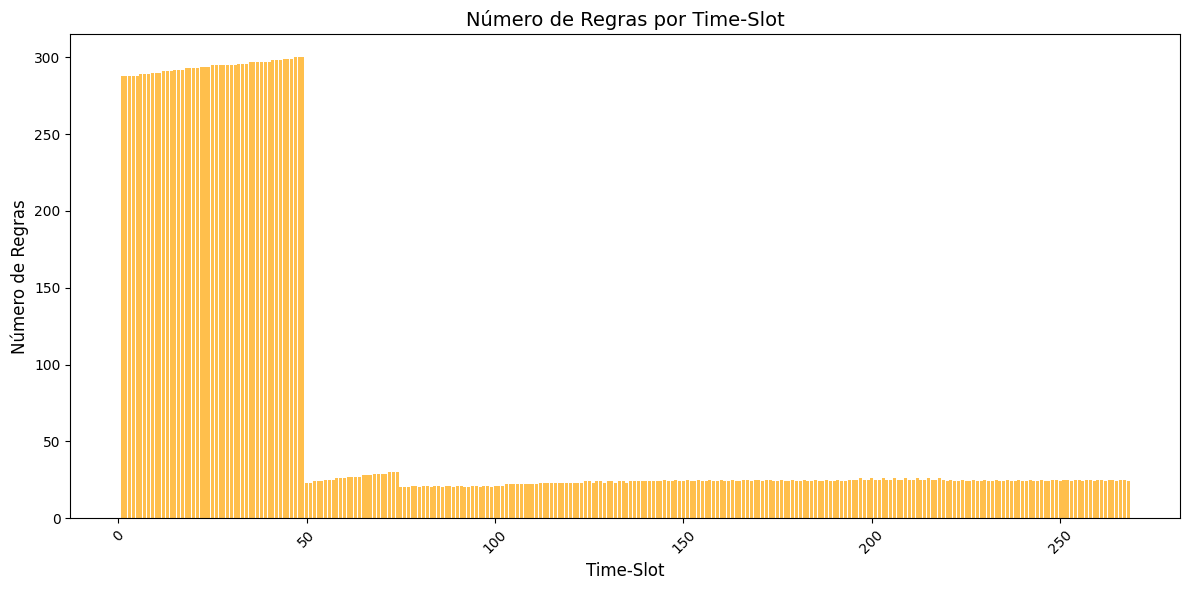

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_time_vs_rules(csv_file):
    """
    Lê um arquivo CSV e plota um gráfico de barras mostrando o número de regras 
    associadas a cada time-slot (tempo).
    
    Parâmetros:
        csv_file (str): Caminho para o arquivo CSV.
    """
    # Lê o arquivo CSV
    data = pd.read_csv(csv_file)
    
    # Verifica as colunas presentes no CSV
    print("Colunas encontradas:", data.columns)
    
    # Cria o gráfico de barras
    plt.figure(figsize=(12, 6))
    plt.bar(data['Time_Slot'], data["Numero_de_Regras"], color='orange', alpha=0.7)

    # Configurações do gráfico
    plt.title('Número de Regras por Time-Slot', fontsize=14)
    plt.xlabel('Time-Slot', fontsize=12)
    plt.ylabel('Número de Regras', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)  # Rotaciona os time-slots no eixo X para melhor visualização
    plt.tight_layout()

    # Exibe o gráfico
    plt.show()

# Exemplo de uso:
plot_time_vs_rules(path)